# Описание проекта

Интернет-магазин «В один клик» продаёт разные товары: для детей, для дома, мелкую бытовую технику, косметику и даже продукты. Отчёт магазина за прошлый период показал, что активность покупателей начала снижаться. Привлекать новых клиентов уже не так эффективно: о магазине и так знает большая часть целевой аудитории. Возможный выход — удерживать активность постоянных клиентов. Сделать это можно с помощью персонализированных предложений.

«В один клик» — современная компания, поэтому её руководство не хочет принимать решения просто так — только на основе анализа данных и бизнес-моделирования.


**Цель:**

Разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.

**Как решать задачу:**

Продумывать подход к решению этой задачи вам не придётся — руководитель отдела его уже сформировал:
1. Нужно промаркировать уровень финансовой активности постоянных покупателей. В компании принято выделять два уровня активности: «снизилась», если клиент стал покупать меньше товаров, и «прежний уровень».
2. Нужно собрать данные по клиентам по следующим группам:
  - Признаки, которые описывают коммуникацию сотрудников компании с клиентом.
  - Признаки, которые описывают продуктовое поведение покупателя. Например, какие товары покупает и как часто.
  - Признаки, которые описывают покупательское поведение клиента. Например, сколько тратил в магазине.
  - Признаки, которые описывают поведение покупателя на сайте. Например, как много страниц просматривает и сколько времени проводит на сайте.


Представим группы признаков (вместе с целевым) в виде диаграммы — такую визуализацию ещё называют диаграммой Исикавы.

1. Нужно построить модель, которая предскажет вероятность снижения покупательской активности клиента в следующие три месяца.
2. В исследование нужно включить дополнительные данные финансового департамента о прибыльности клиента: какой доход каждый покупатель приносил компании за последние три месяца.
3. Используя данные модели и данные о прибыльности клиентов, нужно выделить сегменты покупателей и разработать для них персонализированные предложения.


Руководство одобрило описание решения, и вам, как специалисту по DS, нужно его реализовать.

**Ход исследования**

Данные и общая инфорация будут получены из следующих файлов:
- `/datasets/market_file.csv`;
- `/datasets/market_money.csv`;
- `/datasets/market_time.csv`;
- `/datasets/money.csv`.


О качестве данных в файлах перед их обработкой пока не имеется информации. По данной причине, проведением предобработки и исследованием данных, необходимо провести обзор данных и изучить общую информацию.

Данные будут проверены на пропущенные значения, ошибки и дублированные значения. На этапе предобработки данных, будут исправлены ошибки в данных, которые могут привести к искажению конечного результата исследования. 
При необходимости будут созданы столбцы, исправлены формат некоторых столбцов данных и названия столбцов будут приведены в единый порядок (пример: нижний регистр, названия на английском и вместо пробелов в названии символ `_`)



# Шаг 1. Загрузка данных

In [1]:
#installs

!pip install phik 
!pip install shap
!pip install --upgrade scikit-learn==1.4 -q 

     |████████████████████████████████| 540 kB 1.2 MB/s eta 0:00:01


In [2]:
# imports

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.pyplot as plt
import phik
import shap

from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import (
    StandardScaler,
    OneHotEncoder,
    OrdinalEncoder,
    MinMaxScaler,
    RobustScaler,
    LabelEncoder
)
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.metrics import accuracy_score, roc_auc_score
from sklearn.ensemble import RandomForestClassifier

In [3]:
# Установление нужного формата вывода
pd.set_option('display.float_format', lambda x: '{:.3f}'.format(x))

In [5]:
# Объявляем датафреймы следующим образом
market_df = pd.read_csv('/datasets/market_file.csv')
market_money_df = pd.read_csv('/datasets/market_money.csv')
market_time_df = pd.read_csv('/datasets/market_time.csv')
money_df = pd.read_csv('/datasets/money.csv', sep=';', decimal=',')


dfss_names = ['market_df', 'market_money_df', 'market_time_df', 'money_df']

In [6]:
display(market_df.head())

,id,Покупательская активность,Тип сервиса,Разрешить сообщать,Маркет_актив_6_мес,Маркет_актив_тек_мес,Длительность,Акционные_покупки,Популярная_категория,Средний_просмотр_категорий_за_визит,Неоплаченные_продукты_штук_квартал,Ошибка_сервиса,Страниц_за_визит
0,215348,Снизилась,премиум,да,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,премиум,да,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,стандартт,нет,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,стандартт,да,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,стандартт,нет,5.100,3,1064,0.940,Товары для детей,3,2,3,2


In [7]:
display(market_money_df.head())

,id,Период,Выручка
0,215348,препредыдущий_месяц,0.000
1,215348,текущий_месяц,3293.100
2,215348,предыдущий_месяц,0.000
3,215349,препредыдущий_месяц,4472.000
4,215349,текущий_месяц,4971.600


In [8]:
display(market_time_df.head())

,id,Период,минут
0,215348,текущий_месяц,14
1,215348,предыдцщий_месяц,13
2,215349,текущий_месяц,10
3,215349,предыдцщий_месяц,12
4,215350,текущий_месяц,13


In [9]:
display(money_df.head())

,id,Прибыль
0,215348,0.980
1,215349,4.160
2,215350,3.130
3,215351,4.870
4,215352,4.210


Пока содержание файлов подходят к их описаниям. Разницы могут возникнуть в следующих шагах задания

**Итоги шага:**

1. Были импортированы необходимые библиотеки
2. Данные файлов были загружены

# Шаг 2. Предобработка данных

In [10]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                               Non-Null Count  Dtype  
---  ------                               --------------  -----  
 0   id                                   1300 non-null   int64  
 1   Покупательская активность            1300 non-null   object 
 2   Тип сервиса                          1300 non-null   object 
 3   Разрешить сообщать                   1300 non-null   object 
 4   Маркет_актив_6_мес                   1300 non-null   float64
 5   Маркет_актив_тек_мес                 1300 non-null   int64  
 6   Длительность                         1300 non-null   int64  
 7   Акционные_покупки                    1300 non-null   float64
 8   Популярная_категория                 1300 non-null   object 
 9   Средний_просмотр_категорий_за_визит  1300 non-null   int64  
 10  Неоплаченные_продукты_штук_квартал   1300 non-null   int64  
 11  Ошибка_сервиса                

In [11]:
display(market_df.isna().sum())
market_df.nunique()

id                                     0
Покупательская активность              0
Тип сервиса                            0
Разрешить сообщать                     0
Маркет_актив_6_мес                     0
Маркет_актив_тек_мес                   0
Длительность                           0
Акционные_покупки                      0
Популярная_категория                   0
Средний_просмотр_категорий_за_визит    0
Неоплаченные_продукты_штук_квартал     0
Ошибка_сервиса                         0
Страниц_за_визит                       0
dtype: int64

id                                     1300
Покупательская активность                 2
Тип сервиса                               3
Разрешить сообщать                        2
Маркет_актив_6_мес                       41
Маркет_актив_тек_мес                      3
Длительность                            658
Акционные_покупки                        42
Популярная_категория                      6
Средний_просмотр_категорий_за_визит       6
Неоплаченные_продукты_штук_квартал       11
Ошибка_сервиса                           10
Страниц_за_визит                         20
dtype: int64

In [12]:
# Приводим названия столбцов датафрейма 
# market_df к единому порядку
market_df = market_df.rename(columns={'Покупательская активность': 'customer_activity', \
                                      'Тип сервиса': 'service_type', \
                                     'Разрешить сообщать': 'allow_notifications', \
                                      'Маркет_актив_6_мес': 'market_activ_6_months', \
                                     'Маркет_актив_тек_мес': 'market_activ_curr_month', \
                                      'Длительность': 'duration', \
                                     'Акционные_покупки': 'promotional_purchases', \
                                      'Популярная_категория': 'popular_category', \
                                     'Средний_просмотр_категорий_за_визит': 'average_cat_views_per_visit', \
                                     'Неоплаченные_продукты_штук_квартал': 'unpaid_products_quarterly', \
                                      'Ошибка_сервиса': 'service_errors', \
                                     'Страниц_за_визит': 'pages_per_visit'})


**Описание к изменениям названий столбцов датафрейма market_df**

- Покупательская активность — customer_activity
- Тип сервиса — service_type
- Разрешить сообщать — allow_notifications
- Маркет_актив_6_мес — marketing_activity_6_months
- Маркет_актив_тек_мес — marketing_activity_current_month
- Длительность — duration
- Акционные_покупки — promotional_purchases
- Популярная_категория — popular_category
- Средний_просмотр_категорий_за_визит — average_category_views_per_visit
- Неоплаченные_продукты_штук_квартал — unpaid_products_quarterly
- Ошибка_сервиса — service_errors
- Страниц_за_визит — pages_per_visit

In [13]:
market_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   customer_activity            1300 non-null   object 
 2   service_type                 1300 non-null   object 
 3   allow_notifications          1300 non-null   object 
 4   market_activ_6_months        1300 non-null   float64
 5   market_activ_curr_month      1300 non-null   int64  
 6   duration                     1300 non-null   int64  
 7   promotional_purchases        1300 non-null   float64
 8   popular_category             1300 non-null   object 
 9   average_cat_views_per_visit  1300 non-null   int64  
 10  unpaid_products_quarterly    1300 non-null   int64  
 11  service_errors               1300 non-null   int64  
 12  pages_per_visit              1300 non-null   int64  
dtypes: float64(2), int

Названия столбцов изменены успешно!

In [14]:
# Проверяем датафрейм market_df на дубликаты 
print('customer_activity: ')
display(market_df['customer_activity'].value_counts())

print('service_type: ')
display(market_df['service_type'].value_counts())

print('allow_notifications: ')
market_df['allow_notifications'].value_counts()

customer_activity: 


Прежний уровень    802
Снизилась          498
Name: customer_activity, dtype: int64

service_type: 


стандарт     914
премиум      376
стандартт     10
Name: service_type, dtype: int64

allow_notifications: 


да     962
нет    338
Name: allow_notifications, dtype: int64

Найдены 10 явных дубликатов в столбце `service_type` - значение `стандартт`

In [15]:
market_df['service_type'] = market_df['service_type'].replace({'стандартт': 'стандарт'})
display(market_df['service_type'].value_counts())

стандарт    924
премиум     376
Name: service_type, dtype: int64

Значения явных дубликатов изменены на корректные

In [16]:
service_type_replacement = {'премиум': 1, 'стандарт': 0}
allow_notifications_replacement = {'да': 1, 'нет': 0}


market_df['service_type'] = (
    market_df['service_type'].replace(service_type_replacement)
)

market_df['allow_notifications'] = (
    market_df['allow_notifications'].replace(allow_notifications_replacement)
)

**Описание к изменениям значений столбцов датафрейма market_df:**

Столбец `service_type`: 
- стандарт   - 0
- премиум    - 1 

Столбец `allow_notifications`: 
- да     - 1
- нет    - 0 


In [17]:
market_df.head()

,id,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit
0,215348,Снизилась,1,1,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,1,1,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,0,0,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,0,1,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,0,0,5.100,3,1064,0.940,Товары для детей,3,2,3,2


In [18]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   Период   3900 non-null   object 
 2   Выручка  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [19]:
# Проверяем датафрейм market_money_df на пропущенные значения
print("Пропущенные значения: ")
display(market_money_df.isna().sum())
# Выводим количество уникальных значений датафрейма market_money_df
print("Количество уникальных значений: ")
display(market_money_df.nunique())

# Выводим количество значений датафрейма market_money_df
# столбца Период
market_money_df['Период'].value_counts()

Пропущенные значения: 


id         0
Период     0
Выручка    0
dtype: int64

Количество уникальных значений: 


id         1300
Период        3
Выручка    2776
dtype: int64

препредыдущий_месяц    1300
текущий_месяц          1300
предыдущий_месяц       1300
Name: Период, dtype: int64

In [20]:
# Приводим названия столбцов датафрейма 
# market_money_df к единому порядку
market_money_df = market_money_df.rename(columns={'Период': 'period', 'Выручка': 'revenue'})


**Описание изменений к столбцам датафрейма market_money_df**

- период — period
- выручка — revenue

In [21]:
market_money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


In [22]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   id      2600 non-null   int64 
 1   Период  2600 non-null   object
 2   минут   2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [23]:
# Проверяем датафрейма market_time_df на пропущенные значения
print("Пропущенные значения: ")
display(market_time_df.isna().sum())
# Выводим количество уникальных значений датафрейма market_time_df
print("Количество уникальных значений: ")
display(market_time_df.nunique())

# Выводим количество значений датафрейма market_time_df
# столбца Период
market_time_df['Период'].value_counts()

Пропущенные значения: 


id        0
Период    0
минут     0
dtype: int64

Количество уникальных значений: 


id        1300
Период       2
минут       20
dtype: int64

предыдцщий_месяц    1300
текущий_месяц       1300
Name: Период, dtype: int64

In [24]:
market_time_df = market_time_df.rename(columns={'Период': 'period', 'минут': 'minute'})


**Описание изменений к столбцам датафрейма market_time_df**

- период — period
- минут — minute

In [25]:
# Исправляем ошибочное значение столбца period датафрейма market_time_df
market_time_df['period'] = market_time_df['period'].replace({'предыдцщий_месяц': 'предыдущий_месяц'})
display(market_time_df['period'].value_counts())

текущий_месяц       1300
предыдущий_месяц    1300
Name: period, dtype: int64

In [26]:
# Проверяем датафрейм money_df на пропущенные значения
money_df.info()

# Выводим количество уникальных значений датафрейма money_df
display(money_df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       1300 non-null   int64  
 1   Прибыль  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


id         0
Прибыль    0
dtype: int64

In [27]:
# Изменяем название столбцов датафрейма money_df
money_df = money_df.rename(columns={'Прибыль': 'profit'})
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


**Итоги шага:**

1. Датафреймы были проверены на пропущенные значения, неявные и явные дубликаты в значениях.
2. Названия столбцов датафрейма `market_df` были приведени к единому порядку.
3. Дубликаты были ликвидированы в датафрейме `market_df`.
4. Значения следующих столбцов датафрейма `market_df` были преобразованы в бинарные:
- `service_type`;
- `allow_notifications`.
5. Названия столбцов датафрейма `market_money_df` были приведены к единому порядку.
6. Названия столбоцв датафрейма `market_time_df` были приведены к единому порядку.
7. Допущенные ошибки в значениях датафрейма `market_time_df` были исправлены.
8. Названия столбцов датафрейма `money_df` были приведены к единому порядку.

# Шаг 3. Исследовательский анализ данных

In [28]:
# Выводим значения датафрейма market_df для исследования
display(market_df.head())
market_df.describe()

,id,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit
0,215348,Снизилась,1,1,3.400,5,121,0.000,Товары для детей,6,2,1,5
1,215349,Снизилась,1,1,4.400,4,819,0.750,Товары для детей,4,4,2,5
2,215350,Снизилась,0,0,4.900,3,539,0.140,Домашний текстиль,5,2,1,5
3,215351,Снизилась,0,1,3.200,5,896,0.990,Товары для детей,5,0,6,4
4,215352,Снизилась,0,0,5.100,3,1064,0.940,Товары для детей,3,2,3,2


,id,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit
count,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000,1300.000
mean,215997.500,0.289,0.740,4.254,4.012,601.898,0.320,3.270,2.840,4.185,8.177
std,375.422,0.454,0.439,1.015,0.697,249.856,0.250,1.355,1.971,1.955,3.978
min,215348.000,0.000,0.000,0.900,3.000,110.000,0.000,1.000,0.000,0.000,1.000
25%,215672.750,0.000,0.000,3.700,4.000,405.500,0.170,2.000,1.000,3.000,5.000
50%,215997.500,0.000,1.000,4.200,4.000,606.000,0.240,3.000,3.000,4.000,8.000
75%,216322.250,1.000,1.000,4.900,4.000,806.000,0.300,4.000,4.000,6.000,11.000
max,216647.000,1.000,1.000,6.600,5.000,1079.000,0.990,6.000,10.000,9.000,20.000


In [29]:
market_money_df.describe()

,id,revenue
count,3900.000,3900.000
mean,215997.500,5025.696
std,375.326,1777.704
min,215348.000,0.000
25%,215672.750,4590.150
50%,215997.500,4957.500
75%,216322.250,5363.000
max,216647.000,106862.200


In [30]:
market_time_df.describe()

,id,minute
count,2600.000,2600.000
mean,215997.500,13.336
std,375.350,4.080
min,215348.000,4.000
25%,215672.750,10.000
50%,215997.500,13.000
75%,216322.250,16.000
max,216647.000,23.000


In [31]:
money_df.describe()

,id,profit
count,1300.000,1300.000
mean,215997.500,3.997
std,375.422,1.014
min,215348.000,0.860
25%,215672.750,3.300
50%,215997.500,4.045
75%,216322.250,4.670
max,216647.000,7.430


In [32]:
market_df.customer_activity.unique()

array(['Снизилась', 'Прежний уровень'], dtype=object)

,id,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,period,revenue
0,215348,Снизилась,1,1,3.400,5,121,0.000,Товары для детей,6,2,1,5,препредыдущий_месяц,0.000
1,215348,Снизилась,1,1,3.400,5,121,0.000,Товары для детей,6,2,1,5,текущий_месяц,3293.100
2,215348,Снизилась,1,1,3.400,5,121,0.000,Товары для детей,6,2,1,5,предыдущий_месяц,0.000
3,215349,Снизилась,1,1,4.400,4,819,0.750,Товары для детей,4,4,2,5,препредыдущий_месяц,4472.000
4,215349,Снизилась,1,1,4.400,4,819,0.750,Товары для детей,4,4,2,5,текущий_месяц,4971.600


count     3900.000
mean      5025.696
std       1777.704
min          0.000
25%       4590.150
50%       4957.500
75%       5363.000
max     106862.200
Name: revenue, dtype: float64

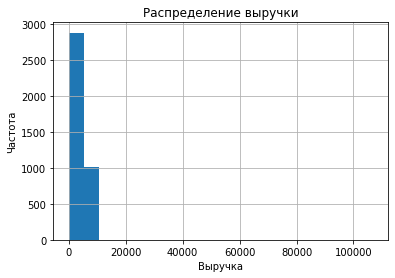

Общее количество активных клиентов: 3900
Общая прибыль: 19600214.6


In [33]:
# Фильтрация клиентов с покупательской активностью не менее трёх месяцев

active_customers_finder = market_df[(market_df['customer_activity'] == 'Прежний уровень')\
                             | (market_df['customer_activity'] == 'Снизилась')]


# Объединение данных с информацией о прибыли
active_customers_with_revenue = active_customers_finder.merge(market_money_df, on='id', how='inner')

# Вывод первых нескольких строк объединённого датафрейма
display(active_customers_with_revenue.head())

# Вывод основных статистических показателей по прибыли
display(active_customers_with_revenue['revenue'].describe())

# Визуализация данных, если необходимо
# Например, гистограмма распределения прибыли
plt.hist(active_customers_with_revenue['revenue'], bins=20)
plt.xlabel('Выручка')
plt.ylabel('Частота')
plt.title('Распределение выручки')
plt.grid()
plt.show()

# Вывод общего числа клиентов и их прибыли
total_customers = len(active_customers_with_revenue)
total_revenue = active_customers_with_revenue['revenue'].sum()
print(f"Общее количество активных клиентов: {total_customers}")
print(f"Общая прибыль: {total_revenue}")


In [34]:
active_customers_with_revenue.period.unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

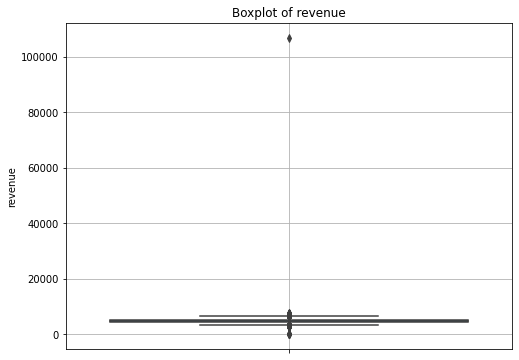

In [35]:
# Ящик с усами
plt.figure(figsize=(8, 6))
sns.boxplot(y=active_customers_with_revenue['revenue'])
plt.title(f'Boxplot of revenue')
plt.ylabel('revenue')
plt.grid(True)
plt.show()

По построенному графику можно понять, что в столбец `revenue` есть выбросы в данных

In [36]:
active_customers_with_revenue['revenue'].describe()

count     3900.000
mean      5025.696
std       1777.704
min          0.000
25%       4590.150
50%       4957.500
75%       5363.000
max     106862.200
Name: revenue, dtype: float64

In [37]:
# Создаем функцию удаления выбросов выше IQR
def drop_of_outliers_in_revenue_above(dataframe, value):
    dataframe.drop(dataframe[dataframe['revenue'] >= value].index, inplace=True)
    return dataframe

value_active_customers_with_revenue_above = 100000.0

# active_customers_with_revenue = 
drop_of_outliers_in_revenue_above(
    active_customers_with_revenue, 
    value_active_customers_with_revenue_above
)
active_customers_with_revenue.revenue.describe()

count   3899.000
mean    4999.577
std      707.000
min        0.000
25%     4590.100
50%     4957.000
75%     5363.000
max     7799.400
Name: revenue, dtype: float64

In [38]:
# Проверяем количество выбросов ниже IQR
active_customers_with_revenue[active_customers_with_revenue[
    'revenue'
] <= 2500
].count()

id                             6
customer_activity              6
service_type                   6
allow_notifications            6
market_activ_6_months          6
market_activ_curr_month        6
duration                       6
promotional_purchases          6
popular_category               6
average_cat_views_per_visit    6
unpaid_products_quarterly      6
service_errors                 6
pages_per_visit                6
period                         6
revenue                        6
dtype: int64

In [39]:
# Создаем функцию удаления выбросов ниже IQR
def drop_of_outliers_in_revenue_below(dataframe, value):
    dataframe.drop(dataframe[dataframe['revenue'] <= value].index, inplace=True)
    return dataframe

value_active_customers_with_revenue_below = 2500

drop_of_outliers_in_revenue_below(
    active_customers_with_revenue, 
    value_active_customers_with_revenue_below
)
active_customers_with_revenue.revenue.describe()

count   3893.000
mean    5007.283
std      679.725
min     2758.700
25%     4592.000
50%     4959.000
75%     5363.000
max     7799.400
Name: revenue, dtype: float64

In [40]:
dfss_names

['market_df', 'market_money_df', 'market_time_df', 'money_df']

In [41]:
# Удаляем значения с выбросами в исходном датафрейме
# чтобы избавиться от них для последующего использования

market_money_df.info()

drop_of_outliers_in_revenue_above(
    market_money_df,
    value_active_customers_with_revenue_above
)

drop_of_outliers_in_revenue_below(
    market_money_df,
    value_active_customers_with_revenue_below
)

market_money_df[market_money_df[
    'revenue'
] >= 100000].count()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3900 entries, 0 to 3899
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   id       3900 non-null   int64  
 1   period   3900 non-null   object 
 2   revenue  3900 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 91.5+ KB


id         0
period     0
revenue    0
dtype: int64

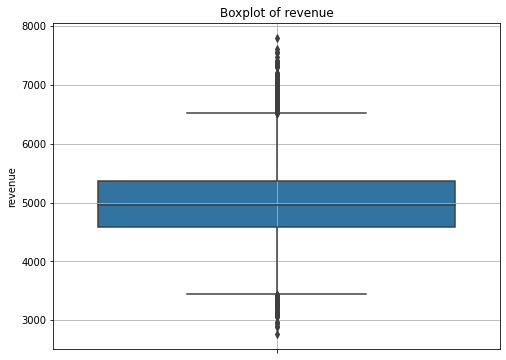

In [43]:
# Ящик с усами
plt.figure(figsize=(8, 6))
sns.boxplot(y=active_customers_with_revenue['revenue'])
plt.title(f'Boxplot of revenue')
plt.ylabel('revenue')
plt.grid(True)
plt.show()

In [44]:
active_customers_with_revenue.info()

active_customers_with_revenue.revenue.describe()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 1 to 3899
Data columns (total 15 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           3893 non-null   int64  
 1   customer_activity            3893 non-null   object 
 2   service_type                 3893 non-null   int64  
 3   allow_notifications          3893 non-null   int64  
 4   market_activ_6_months        3893 non-null   float64
 5   market_activ_curr_month      3893 non-null   int64  
 6   duration                     3893 non-null   int64  
 7   promotional_purchases        3893 non-null   float64
 8   popular_category             3893 non-null   object 
 9   average_cat_views_per_visit  3893 non-null   int64  
 10  unpaid_products_quarterly    3893 non-null   int64  
 11  service_errors               3893 non-null   int64  
 12  pages_per_visit              3893 non-null   int64  
 13  period            

count   3893.000
mean    5007.283
std      679.725
min     2758.700
25%     4592.000
50%     4959.000
75%     5363.000
max     7799.400
Name: revenue, dtype: float64

In [45]:
# Отфильтровать пользователей с активностью менее трех месяцев и с покупками хотя бы в одном из трех месяцев
active_customers_at_least_3_months_with_purchase = active_customers_with_revenue.groupby('id').filter(lambda x: (len(x) >= 3) and (x['revenue'].sum() > 1))


# Удалить пользователей без покупок хотя бы в одном из трех месяцев
active_customers_with_purchase = active_customers_at_least_3_months_with_purchase[active_customers_at_least_3_months_with_purchase['revenue'] > 1]

# Проверка результата
print("Количество уникальных пользователей с покупками в хотя бы одном месяце:", 
      active_customers_with_purchase['id'].nunique())


Количество уникальных пользователей с покупками в хотя бы одном месяце: 1296


In [46]:
active_customers_with_purchase.customer_activity.nunique()

2

In [47]:
active_customers_with_purchase.period.unique()

array(['препредыдущий_месяц', 'текущий_месяц', 'предыдущий_месяц'],
      dtype=object)

**Вывод:**

1. В итоге проведенного анализа, после отдельного вывода клиентов с пользовательской активностью, получились следующие:
- Общее количество активных клиентов: `3900`
- Общая прибыль составила `19600214.6`

2. Средняя прибыль составила:
- `4959`

3. По графику распределения выручки можно сделать вывод, что распределение нормальное.

4. Выбросы были выявлены и удалены в столбце `revenue`


5. Был проведен анализ пользователей с покупками хотя бы в одном из последних 3-х месяцев.Уникальное количество составило `1296`


# Шаг 4. Объединение таблиц

In [49]:
# Изменяем название столбца period датафрейма market_money_df
market_money_df.rename(columns={'period': 'period_money'}, inplace=True)

# Изменяем название столбца period датафрейма market_time_df
market_time_df.rename(columns={'period': 'period_time'}, inplace=True)

market_money_df.info()
print()
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 3893 entries, 1 to 3899
Data columns (total 3 columns):
 #   Column        Non-Null Count  Dtype  
---  ------        --------------  -----  
 0   id            3893 non-null   int64  
 1   period_money  3893 non-null   object 
 2   revenue       3893 non-null   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 121.7+ KB

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2600 non-null   int64 
 1   period_time  2600 non-null   object
 2   minute       2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [50]:
market_time_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2600 entries, 0 to 2599
Data columns (total 3 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   id           2600 non-null   int64 
 1   period_time  2600 non-null   object
 2   minute       2600 non-null   int64 
dtypes: int64(2), object(1)
memory usage: 61.1+ KB


In [51]:
pivot_market_money_df = market_money_df.pivot_table(index='id', columns='period_money', values='revenue', aggfunc='mean')

pivot_market_money_df.info()
pivot_market_money_df.head()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1300 entries, 215348 to 216647
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   предыдущий_месяц     1297 non-null   float64
 1   препредыдущий_месяц  1297 non-null   float64
 2   текущий_месяц        1299 non-null   float64
dtypes: float64(3)
memory usage: 40.6 KB


period_money,предыдущий_месяц,препредыдущий_месяц,текущий_месяц
id,,,
215348,NaN,NaN,3293.100
215349,5216.000,4472.000,4971.600
215350,5457.500,4826.000,5058.400
215351,6158.000,4793.000,6610.400
215352,5807.500,4594.000,5872.500


In [52]:
pivot_market_money_df.dropna(inplace=True)
pivot_market_money_df.info()
pivot_market_money_df.shape[0]

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 3 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   предыдущий_месяц     1296 non-null   float64
 1   препредыдущий_месяц  1296 non-null   float64
 2   текущий_месяц        1296 non-null   float64
dtypes: float64(3)
memory usage: 40.5 KB


1296

In [53]:
pivot_market_time_df = market_time_df.pivot_table(index='id', columns='period_time', values='minute', aggfunc='mean')
pivot_market_time_df.head()

period_time,предыдущий_месяц,текущий_месяц
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [54]:
pivot_market_time_df.isna().sum()

period_time
предыдущий_месяц    0
текущий_месяц       0
dtype: int64

In [55]:
market_df.info()
market_df.isna().sum()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 13 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1300 non-null   int64  
 1   customer_activity            1300 non-null   object 
 2   service_type                 1300 non-null   int64  
 3   allow_notifications          1300 non-null   int64  
 4   market_activ_6_months        1300 non-null   float64
 5   market_activ_curr_month      1300 non-null   int64  
 6   duration                     1300 non-null   int64  
 7   promotional_purchases        1300 non-null   float64
 8   popular_category             1300 non-null   object 
 9   average_cat_views_per_visit  1300 non-null   int64  
 10  unpaid_products_quarterly    1300 non-null   int64  
 11  service_errors               1300 non-null   int64  
 12  pages_per_visit              1300 non-null   int64  
dtypes: float64(2), int

id                             0
customer_activity              0
service_type                   0
allow_notifications            0
market_activ_6_months          0
market_activ_curr_month        0
duration                       0
promotional_purchases          0
popular_category               0
average_cat_views_per_visit    0
unpaid_products_quarterly      0
service_errors                 0
pages_per_visit                0
dtype: int64

In [57]:
pivot_market_money_df = pivot_market_money_df.rename(
    columns={
    'предыдущий_месяц': 'предыдущий_месяц_money',\
    'препредыдущий_месяц': 'препредыдущий_месяц_money',\
    'текущий_месяц': 'текущий_месяц_money'
})
pivot_market_money_df.head()

period_money,предыдущий_месяц_money,препредыдущий_месяц_money,текущий_месяц_money
id,,,
215349,5216.000,4472.000,4971.600
215350,5457.500,4826.000,5058.400
215351,6158.000,4793.000,6610.400
215352,5807.500,4594.000,5872.500
215353,4738.500,5124.000,5388.500


In [59]:
pivot_market_time_df = pivot_market_time_df.rename(
    columns={
        'предыдущий_месяц': 'предыдущий_месяц_period',\
        'текущий_месяц': 'текущий_месяц_period'
    }
)
pivot_market_time_df.head()

period_time,предыдущий_месяц_period,текущий_месяц_period
id,,
215348,13,14
215349,12,10
215350,8,13
215351,11,13
215352,8,11


In [61]:
merged_df = pd.merge(pivot_market_money_df, pivot_market_time_df, on='id', how='inner')

merged_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 215349 to 216647
Data columns (total 5 columns):
 #   Column                     Non-Null Count  Dtype  
---  ------                     --------------  -----  
 0   предыдущий_месяц_money     1296 non-null   float64
 1   препредыдущий_месяц_money  1296 non-null   float64
 2   текущий_месяц_money        1296 non-null   float64
 3   предыдущий_месяц_period    1296 non-null   int64  
 4   текущий_месяц_period       1296 non-null   int64  
dtypes: float64(3), int64(2)
memory usage: 60.8 KB


In [62]:
# Объединение датафрейма merged_df с основным датафреймом market_df
# и объявление нового датафрейма final_df
final_df = pd.merge(market_df, merged_df, on='id', how='inner')
final_df.shape[0]

1296

In [63]:
final_df.head()

,id,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,предыдущий_месяц_money,препредыдущий_месяц_money,текущий_месяц_money,предыдущий_месяц_period,текущий_месяц_period
0,215349,Снизилась,1,1,4.400,4,819,0.750,Товары для детей,4,4,2,5,5216.000,4472.000,4971.600,12,10
1,215350,Снизилась,0,0,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,5457.500,4826.000,5058.400,8,13
2,215351,Снизилась,0,1,3.200,5,896,0.990,Товары для детей,5,0,6,4,6158.000,4793.000,6610.400,11,13
3,215352,Снизилась,0,0,5.100,3,1064,0.940,Товары для детей,3,2,3,2,5807.500,4594.000,5872.500,8,11
4,215353,Снизилась,0,1,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,4738.500,5124.000,5388.500,10,10


In [64]:
# Создаем новый датафрейм без столбца 'id' финального датафрейма
# для дальнейшего использования при корреляционном анализе
final_df_no_id = final_df.drop(columns='id')
final_df_no_id.head()

,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,предыдущий_месяц_money,препредыдущий_месяц_money,текущий_месяц_money,предыдущий_месяц_period,текущий_месяц_period
0,Снизилась,1,1,4.400,4,819,0.750,Товары для детей,4,4,2,5,5216.000,4472.000,4971.600,12,10
1,Снизилась,0,0,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,5457.500,4826.000,5058.400,8,13
2,Снизилась,0,1,3.200,5,896,0.990,Товары для детей,5,0,6,4,6158.000,4793.000,6610.400,11,13
3,Снизилась,0,0,5.100,3,1064,0.940,Товары для детей,3,2,3,2,5807.500,4594.000,5872.500,8,11
4,Снизилась,0,1,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,4738.500,5124.000,5388.500,10,10


In [65]:
final_df_no_id.shape

(1296, 17)

**Вывод:**

Используемые обозначения:
- СТ - сводная таблица
- ИДФ - исходный датафрейм


1. Для объединения данных была создана СТ `pivot_market_money_df` на основе ИДФ `market_money_df`. Индексом таблицы был выбран признак `id`, в то время как столбцы были сформированы на основе уникальных значений из столбца `period_money` ИДФ. Значения в ячейках СТ были взяты из столбца `revenue` ИДФ. Для агрегации данных в СТ был использован метод `mean`, представляющий среднее значение.

2. В СТ `pivot_market_money_df` были удалены пропущенные значения, после чего количество значений СТ составило 1296.

3. Для объединения данных была создана СТ `pivot_market_time_df` на основе ИДФ `market_time_df`. Индексом таблицы был выбран признак `id`, в то время как столбцы были сформированы на основе уникальных значений столбца `period_time` ИДФ. Значения в ячейках СТ были взяты из столбца `minute` ИДФ. Для агрегации данных в СТ был использован метод `mean`, представляющий среднее значение.

4. СТ `pivot_market_time_df` был проверен на пропущенные значения. Количество значений СТ составило 1300.

5. Названия столбцов СТ `pivot_market_money_df` были изменены на следующие:
- `предыдущий_месяц` - `предыдущий_месяц_money`
- `препредыдущий_месяц` - `препредыдущий_месяц_money`
- `текущий_месяц` - `текущий_месяц_money`

6. Названия столбцов СТ `pivot_market_time_df` были изменены на следующие:
- `предыдущий_месяц` - `предыдущий_месяц_period`
- `текущий_месяц` - `текущий_месяц_period`

7. В конечном результате сводные таблицы `pivot_market_money_df`, `pivot_market_time_df` и исходный датафрейм `market_df` были объединены в датафрейм `final_df` по признаку `id`

8. Был создан дополнительный датафрейм `final_df_no_id`, который не хранит в себе признак `id`, для корреляционного анализа в дальнейшем


# Шаг 5. Корреляционный анализ

In [67]:
final_df_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_activity            1296 non-null   object 
 1   service_type                 1296 non-null   int64  
 2   allow_notifications          1296 non-null   int64  
 3   market_activ_6_months        1296 non-null   float64
 4   market_activ_curr_month      1296 non-null   int64  
 5   duration                     1296 non-null   int64  
 6   promotional_purchases        1296 non-null   float64
 7   popular_category             1296 non-null   object 
 8   average_cat_views_per_visit  1296 non-null   int64  
 9   unpaid_products_quarterly    1296 non-null   int64  
 10  service_errors               1296 non-null   int64  
 11  pages_per_visit              1296 non-null   int64  
 12  предыдущий_месяц_money       1296 non-null   float64
 13  препредыдущий_меся

In [68]:
### Примечание ###
# Данная ячейка может отрабатываться больше чем обычно #

# Список непрерывных признаков, которые необходимо исключить из анализа
# interval_cols_final_df_no_id = ['service_type', 'allow_notifications', 'revenue']
interval_cols_final_df_no_id = [
    'предыдущий_месяц_money',\
    'market_activ_curr_month',
    'duration',
    'promotional_purchases',
    'average_cat_views_per_visit',
    'unpaid_products_quarterly',
    'service_errors',
    'pages_per_visit',
    'препредыдущий_месяц_money',\
    'текущий_месяц_money',
    'предыдущий_месяц_period',
    'текущий_месяц_period'
]

# Вычисление матрицы phik с учетом непрерывных признаков
phik_matrix = final_df_no_id.phik_matrix(interval_cols=interval_cols_final_df_no_id)
# phik_matrix = final_df_no_id.phik_matrix

In [69]:
final_df_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_activity            1296 non-null   object 
 1   service_type                 1296 non-null   int64  
 2   allow_notifications          1296 non-null   int64  
 3   market_activ_6_months        1296 non-null   float64
 4   market_activ_curr_month      1296 non-null   int64  
 5   duration                     1296 non-null   int64  
 6   promotional_purchases        1296 non-null   float64
 7   popular_category             1296 non-null   object 
 8   average_cat_views_per_visit  1296 non-null   int64  
 9   unpaid_products_quarterly    1296 non-null   int64  
 10  service_errors               1296 non-null   int64  
 11  pages_per_visit              1296 non-null   int64  
 12  предыдущий_месяц_money       1296 non-null   float64
 13  препредыдущий_меся

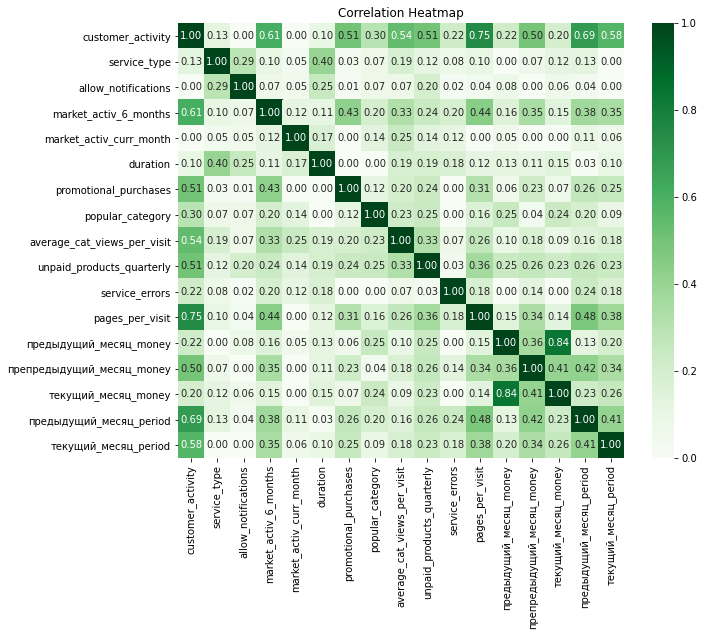

In [70]:
# Создание тепловой карты для матрицы корреляции
plt.figure(figsize=(10, 8))
sns.heatmap(phik_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

**Комментарий к тепловой карте корреляции**

Как видно на вышепостроенной тепловой карте, можно понять, что между признаками `unpaid_products_quarterly` и `duration` наблюдается мультиколлинеарность, которых необходимо устранить.

In [71]:
correlated_columns_to_drop_no_id = ['unpaid_products_quarterly', 'duration']

final_df_filtered_no_id = final_df_no_id#.drop(columns=correlated_columns_to_drop_no_id)
final_df_filtered_no_id.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 17 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   customer_activity            1296 non-null   object 
 1   service_type                 1296 non-null   int64  
 2   allow_notifications          1296 non-null   int64  
 3   market_activ_6_months        1296 non-null   float64
 4   market_activ_curr_month      1296 non-null   int64  
 5   duration                     1296 non-null   int64  
 6   promotional_purchases        1296 non-null   float64
 7   popular_category             1296 non-null   object 
 8   average_cat_views_per_visit  1296 non-null   int64  
 9   unpaid_products_quarterly    1296 non-null   int64  
 10  service_errors               1296 non-null   int64  
 11  pages_per_visit              1296 non-null   int64  
 12  предыдущий_месяц_money       1296 non-null   float64
 13  препредыдущий_меся

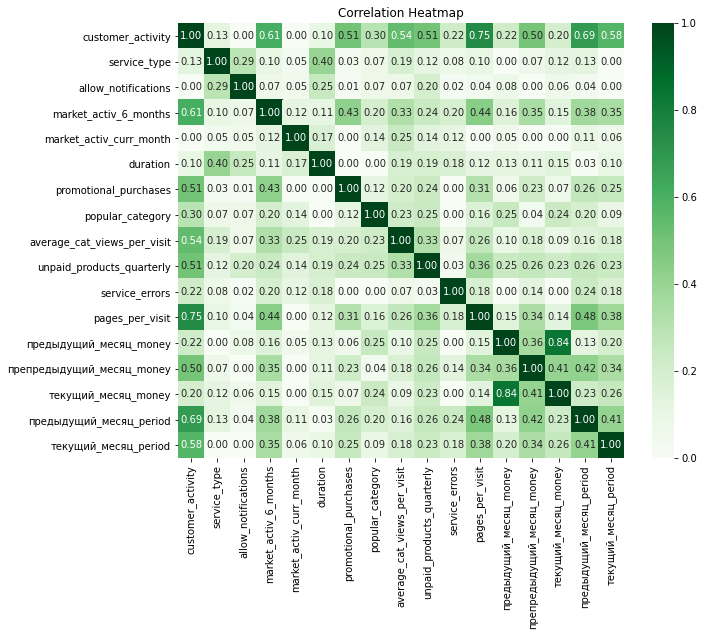

In [72]:
final_df_filtered_phik_matrix = (
    final_df_filtered_no_id.phik_matrix(
        interval_cols=interval_cols_final_df_no_id
                                 )
)

plt.figure(figsize=(10, 8))
sns.heatmap(final_df_filtered_phik_matrix, annot=True, cmap='Greens', fmt=".2f")
plt.title("Correlation Heatmap")
plt.show()

In [73]:
correlated_columns_to_drop_inplace = ['unpaid_products_quarterly', 'duration']

final_df_filtered = final_df #.drop(columns=correlated_columns_to_drop_inplace)
final_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1296 non-null   int64  
 1   customer_activity            1296 non-null   object 
 2   service_type                 1296 non-null   int64  
 3   allow_notifications          1296 non-null   int64  
 4   market_activ_6_months        1296 non-null   float64
 5   market_activ_curr_month      1296 non-null   int64  
 6   duration                     1296 non-null   int64  
 7   promotional_purchases        1296 non-null   float64
 8   popular_category             1296 non-null   object 
 9   average_cat_views_per_visit  1296 non-null   int64  
 10  unpaid_products_quarterly    1296 non-null   int64  
 11  service_errors               1296 non-null   int64  
 12  pages_per_visit              1296 non-null   int64  
 13  предыдущий_месяц_m

**Вывод:**

1. Корреляционный анализ был проведен методом Фик
2. Из корреляционного анализа были исключены следующие признаки:
- `service_type`
- `allow_notifications`
- `предыдущий_месяц_money`
- `препредыдущий_месяц_money`
- `текущий_месяц_money`
3. Была построена тепловая матрица корреляции для проведения корреляционного анализа
4. Была выявлена мультиколлинеарность между признаками `unpaid_products_quarterly` и `duration`. Данные признаки были удалены

# Шаг 6. Использование пайплайнов

In [75]:
final_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1296 non-null   int64  
 1   customer_activity            1296 non-null   object 
 2   service_type                 1296 non-null   int64  
 3   allow_notifications          1296 non-null   int64  
 4   market_activ_6_months        1296 non-null   float64
 5   market_activ_curr_month      1296 non-null   int64  
 6   duration                     1296 non-null   int64  
 7   promotional_purchases        1296 non-null   float64
 8   popular_category             1296 non-null   object 
 9   average_cat_views_per_visit  1296 non-null   int64  
 10  unpaid_products_quarterly    1296 non-null   int64  
 11  service_errors               1296 non-null   int64  
 12  pages_per_visit              1296 non-null   int64  
 13  предыдущий_месяц_m

In [76]:
final_df_filtered_mapping = {1: 'премиум', 0: 'стандарт'}

final_df_filtered['service_type'] = final_df_filtered['service_type'].map(final_df_filtered_mapping)
final_df_filtered.service_type.head()

0     премиум
1    стандарт
2    стандарт
3    стандарт
4    стандарт
Name: service_type, dtype: object

In [77]:
final_df_filtered['customer_activity'].isna().sum()

0

In [78]:
RANDOM_STATE = 42
TEST_SIZE=0.25

In [79]:
X_train, X_test, y_train, y_test = train_test_split(
    final_df_filtered.drop(['customer_activity'], axis=1),
    final_df_filtered['customer_activity'],
    test_size=TEST_SIZE,
    random_state=RANDOM_STATE,
    stratify=final_df['customer_activity']
)

In [80]:
label_encoder = LabelEncoder()

y_train = label_encoder.fit_transform(y_train)
y_test = label_encoder.transform(y_test)

In [81]:
ohe_columns = ['popular_category', 'allow_notifications']

ord_columns = ['service_type']

num_columns = ['allow_notifications', 'market_activ_6_months',\
               'market_activ_curr_month', 'promotional_purchases',\
               'average_cat_views_per_visit','service_errors', \
               'pages_per_visit', 'duration', 'unpaid_products_quarterly']

In [82]:
ohe_pipe = Pipeline(
    [('simpleImputer_ohe', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ohe', OneHotEncoder(drop='first', handle_unknown='error'))
    ]
)

In [83]:
final_df_filtered.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1296 entries, 0 to 1295
Data columns (total 18 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           1296 non-null   int64  
 1   customer_activity            1296 non-null   object 
 2   service_type                 1296 non-null   object 
 3   allow_notifications          1296 non-null   int64  
 4   market_activ_6_months        1296 non-null   float64
 5   market_activ_curr_month      1296 non-null   int64  
 6   duration                     1296 non-null   int64  
 7   promotional_purchases        1296 non-null   float64
 8   popular_category             1296 non-null   object 
 9   average_cat_views_per_visit  1296 non-null   int64  
 10  unpaid_products_quarterly    1296 non-null   int64  
 11  service_errors               1296 non-null   int64  
 12  pages_per_visit              1296 non-null   int64  
 13  предыдущий_месяц_m

In [84]:
ord_pipe = Pipeline(
    [('simpleImputer_before_ord', SimpleImputer(missing_values=np.nan, strategy='most_frequent')),
    ('ord', OrdinalEncoder(
        categories=[
            ['премиум', 'стандарт']
        ],
        handle_unknown='use_encoded_value', unknown_value=np.nan
    )),
    ]
)

In [85]:
data_preprocessor = ColumnTransformer(
    [
        ('ohe', ohe_pipe, ohe_columns),
        ('ord', ord_pipe, ord_columns),
        ('num', MinMaxScaler(), num_columns)
    ], remainder='passthrough'
)

In [86]:
pipe_final = Pipeline([
    ('preprocessor', data_preprocessor),
    ('models', DecisionTreeClassifier(random_state=RANDOM_STATE))
])

In [87]:
param_grid = [
    {
        'models': [DecisionTreeClassifier(random_state=RANDOM_STATE)],
        'models__max_depth': range(2, 6),
        'models__max_features': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [KNeighborsClassifier()],
        'models__n_neighbors': range(2, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [LogisticRegression(
            random_state=RANDOM_STATE,
            solver='liblinear',
            penalty='l1'
        )],
        'models__C': range(1, 6),
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    },
    {
        'models': [SVC(kernel='linear', random_state=RANDOM_STATE, probability=True)],
        'models__C': [0.1, 1, 10, 100],
        'preprocessor__num': [StandardScaler(), MinMaxScaler(), 'passthrough']
    }
]

In [88]:
randomized_search = RandomizedSearchCV(
    pipe_final,
    param_grid,
    cv=5,
    scoring='roc_auc',
    random_state=RANDOM_STATE,
    n_jobs=-1,
    error_score='raise'
)

randomized_search.fit(X_train, y_train)

RandomizedSearchCV(cv=5, error_score='raise',
                   estimator=Pipeline(steps=[('preprocessor',
                                              ColumnTransformer(remainder='passthrough',
                                                                transformers=[('ohe',
                                                                               Pipeline(steps=[('simpleImputer_ohe',
                                                                                                SimpleImputer(strategy='most_frequent')),
                                                                                               ('ohe',
                                                                                                OneHotEncoder(drop='first'))]),
                                                                               ['popular_category',
                                                                                'allow_notifications']),
                                                                              ('ord',
                                                                               Pipeline(steps=[('simpleImputer_be...
                                        {'models': [LogisticRegression(penalty='l1',
                                                                       random_state=42,
                                                                       solver='liblinear')],
                                         'models__C': range(1, 6),
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']},
                                        {'models': [SVC(kernel='linear',
                                                        probability=True,
                                                        random_state=42)],
                                         'models__C': [0.1, 1, 10, 100],
                                         'preprocessor__num': [StandardScaler(),
                                                               MinMaxScaler(),
                                                               'passthrough']}],
                   random_state=42, scoring='roc_auc')

In [89]:
print("Лучшая модель и её параметры:\n\n", randomized_search.best_estimator_)
print("Метрика лучшей модели на тренировочной выборке:", randomized_search.best_score_)

probabilities = randomized_search.predict_proba(X_test)
probabilities_one = probabilities[:, 1]
print('Площадь ROC-кривой:', roc_auc_score(y_test, probabilities_one))

Лучшая модель и её параметры:

 Pipeline(steps=[('preprocessor',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('ohe',
                                                  Pipeline(steps=[('simpleImputer_ohe',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('ohe',
                                                                   OneHotEncoder(drop='first'))]),
                                                  ['popular_category',
                                                   'allow_notifications']),
                                                 ('ord',
                                                  Pipeline(steps=[('simpleImputer_before_ord',
                                                                   SimpleImputer(strategy='most_frequent')),
                                        

**Вывод:**

1. По полученным результатам можно сделать вывод, что самой лучшей моделью является SVC модель, с такими параметрами как:
- `SVC(C=0.1, kernel='linear', probability=True, random_state=42)`

2. Значения метрики лучшей модели на тренировочной выборке: `0.8777629488993126`
3. Метрика ROC-AUC на тестовой выборке: `0.8989604821421348`

# Шаг 7. Анализ важности признаков

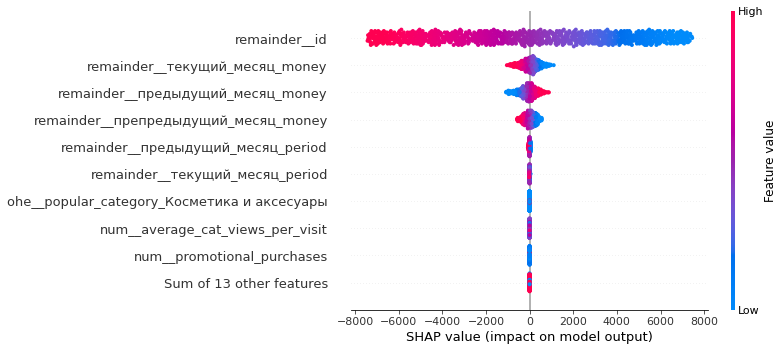

In [91]:
# Получение лучшей модели
best_model = randomized_search.best_estimator_

# Получение преобразователя из pipeline
data_preprocessor = best_model.named_steps['preprocessor']

# Применение преобразований к X_train
X_train_transformed = data_preprocessor.transform(X_train)

feature_names = data_preprocessor.get_feature_names_out()

# Создание explainer с использованием преобразованного X_train
explainer = shap.LinearExplainer(best_model.named_steps['models'], X_train_transformed, feature_names=feature_names)

# Вычисление значений SHAP
shap_values = explainer(X_train_transformed)

# Визуализация
shap.plots.beeswarm(shap_values)


**Вывод:**

1. Самым мало значимым признаком для моделя является `num__market_activ_curr_month`, то есть количество маркетинговых коммуникаций в текущем месяце.

2. Самым сильно влияющим признаком для модели являются следующие топ-3 признака:

- `pages_per_visit` - среднее количество страниц, которые просмотрел покупатель за один визит на сайт за последние 3 месяца
- `average_cat_views_per_visit` - показывает, сколько в среднем категорий покупатель просмотрел за визит в течение последнего месяца.
- `promotional_purchases` - среднемесячная доля покупок по акции от общего числа покупок за последние 6 месяцев.


# Шаг 8. Сегментация покупателей

In [92]:
final_df_filtered.head()

,id,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,предыдущий_месяц_money,препредыдущий_месяц_money,текущий_месяц_money,предыдущий_месяц_period,текущий_месяц_period
0,215349,Снизилась,премиум,1,4.400,4,819,0.750,Товары для детей,4,4,2,5,5216.000,4472.000,4971.600,12,10
1,215350,Снизилась,стандарт,0,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,5457.500,4826.000,5058.400,8,13
2,215351,Снизилась,стандарт,1,3.200,5,896,0.990,Товары для детей,5,0,6,4,6158.000,4793.000,6610.400,11,13
3,215352,Снизилась,стандарт,0,5.100,3,1064,0.940,Товары для детей,3,2,3,2,5807.500,4594.000,5872.500,8,11
4,215353,Снизилась,стандарт,1,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,4738.500,5124.000,5388.500,10,10


In [93]:
money_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1300 entries, 0 to 1299
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   id      1300 non-null   int64  
 1   profit  1300 non-null   float64
dtypes: float64(1), int64(1)
memory usage: 20.4 KB


In [94]:
predicted_probabilities = best_model.predict_proba(final_df_filtered)
predicted_probabilities.sum()

1296.0

In [95]:
money_df_filtered = money_df[money_df['id'].isin(final_df_filtered['id'])]
money_df_filtered.count()

id        1296
profit    1296
dtype: int64

In [96]:
# Предсказание вероятности снижения для каждого клиента
predicted_probabilities = best_model.predict_proba(final_df_filtered)

# Создание DataFrame с предсказаниями вероятности снижения и прибыли
segmentation_df = pd.DataFrame({
    'predicted_probability': predicted_probabilities[:, 1],  
    'profit': money_df_filtered['profit']
})

threshold_probability = 0.7

# Выбор сегмента
segment = segmentation_df[(segmentation_df['predicted_probability'] > threshold_probability)]

# Анализ данных по выбранному сегменту
segment_data = final_df.merge(segment, left_index=True, right_index=True)

display(segment_data.shape[0])

segment_data.head()

424

,id,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,предыдущий_месяц_money,препредыдущий_месяц_money,текущий_месяц_money,предыдущий_месяц_period,текущий_месяц_period,predicted_probability,profit
1,215350,Снизилась,стандарт,0,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,5457.500,4826.000,5058.400,8,13,1.000,4.160
2,215351,Снизилась,стандарт,1,3.200,5,896,0.990,Товары для детей,5,0,6,4,6158.000,4793.000,6610.400,11,13,1.000,3.130
3,215352,Снизилась,стандарт,0,5.100,3,1064,0.940,Товары для детей,3,2,3,2,5807.500,4594.000,5872.500,8,11,1.000,4.870
4,215353,Снизилась,стандарт,1,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,4738.500,5124.000,5388.500,10,10,1.000,4.210
5,215354,Снизилась,стандарт,1,5.100,3,431,0.230,Косметика и аксесуары,2,3,7,2,5685.000,4503.000,5869.600,11,12,1.000,3.950


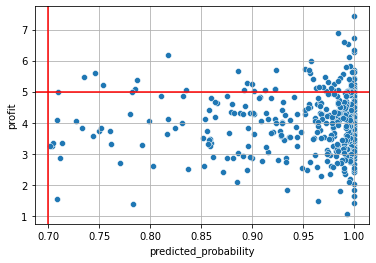

In [97]:
sns.scatterplot(data=segment_data, x='predicted_probability', y='profit')
plt.axvline(x=0.7, color='red')
plt.axhline(y=5, color='red')
plt.grid(True)
plt.show()

In [98]:
segment_data.head()

,id,customer_activity,service_type,allow_notifications,market_activ_6_months,market_activ_curr_month,duration,promotional_purchases,popular_category,average_cat_views_per_visit,unpaid_products_quarterly,service_errors,pages_per_visit,предыдущий_месяц_money,препредыдущий_месяц_money,текущий_месяц_money,предыдущий_месяц_period,текущий_месяц_period,predicted_probability,profit
1,215350,Снизилась,стандарт,0,4.900,3,539,0.140,Домашний текстиль,5,2,1,5,5457.500,4826.000,5058.400,8,13,1.000,4.160
2,215351,Снизилась,стандарт,1,3.200,5,896,0.990,Товары для детей,5,0,6,4,6158.000,4793.000,6610.400,11,13,1.000,3.130
3,215352,Снизилась,стандарт,0,5.100,3,1064,0.940,Товары для детей,3,2,3,2,5807.500,4594.000,5872.500,8,11,1.000,4.870
4,215353,Снизилась,стандарт,1,3.300,4,762,0.260,Домашний текстиль,4,1,1,4,4738.500,5124.000,5388.500,10,10,1.000,4.210
5,215354,Снизилась,стандарт,1,5.100,3,431,0.230,Косметика и аксесуары,2,3,7,2,5685.000,4503.000,5869.600,11,12,1.000,3.950


In [99]:
segment_data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 424 entries, 1 to 444
Data columns (total 20 columns):
 #   Column                       Non-Null Count  Dtype  
---  ------                       --------------  -----  
 0   id                           424 non-null    int64  
 1   customer_activity            424 non-null    object 
 2   service_type                 424 non-null    object 
 3   allow_notifications          424 non-null    int64  
 4   market_activ_6_months        424 non-null    float64
 5   market_activ_curr_month      424 non-null    int64  
 6   duration                     424 non-null    int64  
 7   promotional_purchases        424 non-null    float64
 8   popular_category             424 non-null    object 
 9   average_cat_views_per_visit  424 non-null    int64  
 10  unpaid_products_quarterly    424 non-null    int64  
 11  service_errors               424 non-null    int64  
 12  pages_per_visit              424 non-null    int64  
 13  предыдущий_месяц_mon

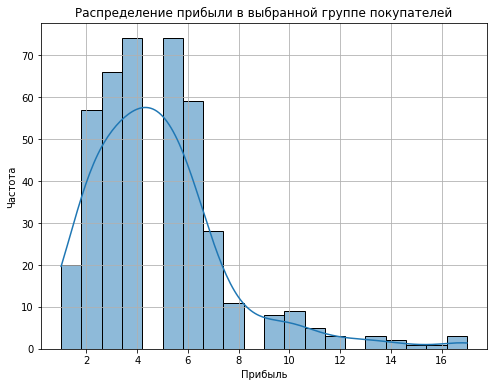

In [100]:
# Построение гистограммы для признака 'pages_per_visit'
plt.figure(figsize=(8, 6))
sns.histplot(data=segment_data, x='pages_per_visit', bins=20, kde=True)
plt.title('Распределение прибыли в выбранной группе покупателей')
plt.xlabel('Прибыль')
plt.ylabel('Частота')
plt.grid(True)
plt.show()


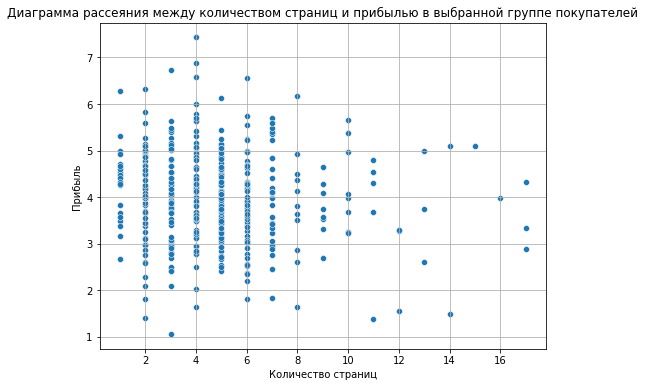

In [101]:
# Построение диаграммы рассеяния между признаками 'pages_per_visit' и 'revenue'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=segment_data, x='pages_per_visit', y='profit')
plt.title('Диаграмма рассеяния между количеством страниц и прибылью в выбранной группе покупателей')
plt.xlabel("Количество страниц")
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

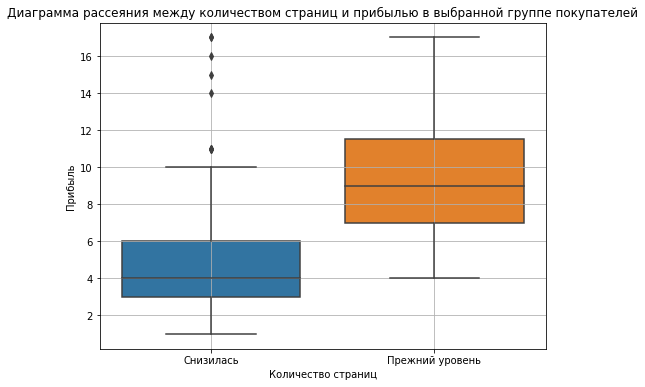

In [102]:
# Построение диаграммы с усами между признаками 'customer_activity' и 'pages_per_visit'
plt.figure(figsize=(8, 6))
sns.boxplot(data=segment_data, x='customer_activity', y='pages_per_visit')
plt.title('Диаграмма рассеяния между количеством страниц и прибылью в выбранной группе покупателей')
plt.xlabel("Количество страниц")
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

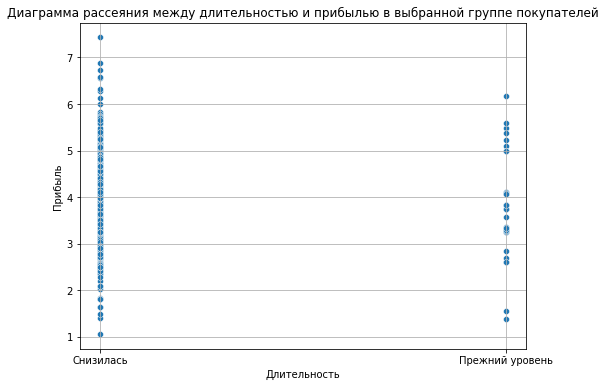

In [103]:
# Построение диаграммы рассеяния между признаками 'customer_activity' и 'revenue'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=segment_data, x='customer_activity', y='profit')
plt.title('Диаграмма рассеяния между длительностью и прибылью в выбранной группе покупателей')
plt.xlabel('Длительность')
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

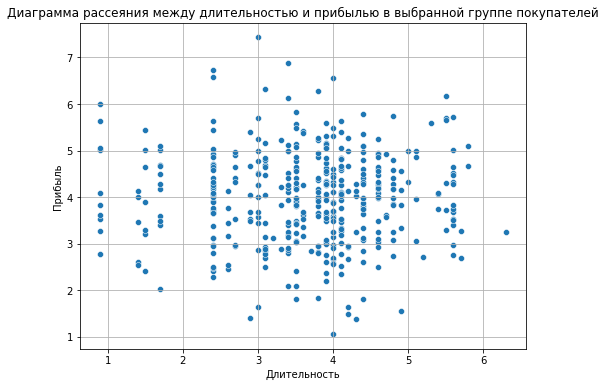

In [104]:
# Построение диаграммы рассеяния между признаками 'market_activ_6_months' и 'revenue'
plt.figure(figsize=(8, 6))
sns.scatterplot(data=segment_data, x='market_activ_6_months', y='profit')
plt.title('Диаграмма рассеяния между длительностью и прибылью в выбранной группе покупателей')
plt.xlabel('Длительность')
plt.ylabel('Прибыль')
plt.grid(True)
plt.show()

**Вывод:**

1. Для данного сегмента были отобраны пользователи, имеющие платную подписку "премиум" к сервису (преобразованные в булевы значения).
2. Для дальнейшего анализа можно выбрать аудиторию, включающую пользователей с платной подпиской "премиум".
3. Для повышения привлекательности и привлечения пользователей к сервису, возможно рекомендовать увеличение количества маркетинговых коммуникаций со стороны компании.

# Шаг 9. Общий вывод

**Общий вывод проектной работы:**
1. Задача проектной работы была разработать решение, которое позволит персонализировать предложения постоянным клиентам, чтобы увеличить их покупательскую активность.
2. Были получены следующие исходящие данные для работы:
- `/datasets/market_file.csv`;
- `/datasets/market_money.csv`;
- `/datasets/market_time.csv`;
- `/datasets/money.csv`.

- Были импортированы необходимые библиотеки
- Файлы были загружены
- Названия столбцов были приведены в единый нижний регистр
- Датафреймы были проверены на пропущенные значения, неявные и явные дубликаты в значениях.
- Названия столбцов датафрейма `market_df` были приведени к единому порядку.
- Дубликаты были ликвидированы в датафрейме `market_df`.
- Значения следующих столбцов датафрейма `market_df` были преобразованы в бинарные:
- `service_type`;
- `allow_notifications`.
- Названия столбцов датафрейма `market_money_df` были приведены к единому порядку.
- Названия столбоцв датафрейма `market_time_df` были приведены к единому порядку.
- Допущенные ошибки в значениях датафрейма `market_time_df` были исправлены.
- Названия столбцов датафрейма `money_df` были приведены к единому порядку.

3. Для поиска лучшей модели, были использованы пайплайны, благодаря которым, была выведена лучшая модель
4. Лучшей моделью стала "LogisticRegression" - модель логистической регрессии
5. Для повышения привлекательности и привлечения пользователей к сервису, возможно рекомендовать увеличение количества маркетинговых коммуникаций со стороны компании.